In [3]:
import cv2
from useful import *
from shape_classes import *
import bisect
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from fourier import *

In [ ]:
layout_name = "1.png"  
layout_path = os.path.join( os.getcwd(), 'images', layout_name)


layout_image = Image.open(layout_path)
image_array = np.array(layout_image)
img = image_array[:,:,0]
# plt.imshow(img)
# plt.show()
img_bin = my_preprocessing(img)
blobs_layout = connected_components(img_bin)

for blob in blobs_layout:
    blob_img = blob.image
    contour, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    gx,gy = sample_polygon_uniformly(contour[0],50)
    contour_sampled = np.column_stack((gx, gy)).astype(np.int32)
    f_descriptors_layout = fourier_descriptors(contour_sampled, 50)

layout_name = "2.png"  
layout_path = os.path.join( os.getcwd(), 'images', layout_name)


layout_image = Image.open(layout_path)
image_array = np.array(layout_image)
img = image_array[:,:,0]
# plt.imshow(img)
# plt.show()
img_bin = my_preprocessing(img)
blobs_layout = connected_components(img_bin)

for blob in blobs_layout:
    blob_img = blob.image
    contour, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    gx,gy = sample_polygon_uniformly(contour[0],50)
    contour_sampled = np.column_stack((gx, gy)).astype(np.int32)
    f_descriptors_SEM = fourier_descriptors(contour_sampled, 50)

# diff = np.abs(f_descriptors_layout - f_descriptors_SEM)
diff = np.abs(np.abs(f_descriptors_layout) - np.abs(f_descriptors_SEM))
similarity = np.mean(diff)
    
print(similarity)

In [ ]:
layout_name = "2.png"  
layout_path = os.path.join( os.getcwd(), 'images', layout_name)


layout_image = Image.open(layout_path)
image_array = np.array(layout_image)
img = my_preprocessing(image_array[:,:,0])
print(sum(sum(img)))
print(type(img))

In [ ]:
import cv2
from useful import *
from shape_classes import *
import bisect
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from fourier import *

layout_name = "36.png"  
path = os.path.join( os.getcwd(), 'images', layout_name)

adaptive_window = Adaptive_window(path, 500)

start_row, end_row, _ = adaptive_window.get_window_rows()
# start_row, end_row = (0, 210)
start_col = 0
end_col = start_col + 500
image = Image.open(path)
print(image.size)
img = np.array( image.crop(( start_col, start_row, end_col, end_row )) ) [:,:,0]
img_bin = my_preprocessing(img)
plt.imshow(img_bin)
plt.show()

start_row, end_row, _ = adaptive_window.get_window_rows()
# start_row, end_row = (0, 210)
start_col = 0
end_col = start_col + 500
image = Image.open(path)
print(image.size)
img = np.array( image.crop(( start_col, start_row, end_col, end_row )) ) [:,:,0]
img_bin = my_preprocessing(img)
plt.imshow(img_bin)
plt.show()

start_row, end_row, _ = adaptive_window.get_window_rows()
# start_row, end_row = (0, 210)
start_col = 0
end_col = start_col + 500
image = Image.open(path)
print(image.size)
img = np.array( image.crop(( start_col, start_row, end_col, end_row )) ) [:,:,0]
img_bin = my_preprocessing(img)
plt.imshow(img_bin)
plt.show()

start_row, end_row, _ = adaptive_window.get_window_rows()
# start_row, end_row = (0, 210)
start_col = 0
end_col = start_col + 500
image = Image.open(path)
print(image.size)
img = np.array( image.crop(( start_col, start_row, end_col, end_row )) ) [:,:,0]
img_bin = my_preprocessing(img)
plt.imshow(img_bin)
plt.show()

In [4]:
import PIL

class Adaptive_window:
    def __init__(self, path, win_col_length):
        self.image = Image.open(path)
        _, self.im_row_length  = self.image.size
        self.horizontal_hop = 200
        self.th = 50
        self.start_row = 0
        self.end_row = self.start_row + self.horizontal_hop
        self.start_col = 0
        self.end_col = self.start_col + win_col_length
        self.is_this_last_rows = False
        self.first_rows_done =  False
        self.cell_width = 0
    
    def get_window_rows(self):

        if self.first_rows_done:
            self.end_row = self.start_row + self.cell_width
        else:
            self.end_row = self.start_row + self.horizontal_hop
            
        if self.end_row >= self.im_row_length:
            self.end_row = self.im_row_length
            self.is_this_last_rows = True
            return self.start_row, self.end_row, self.is_this_last_rows
            
        while True:
            window_bin = my_preprocessing( np.array( self.image.crop(( self.start_col, self.start_row, self.end_col, self.end_row )) )[:,:,0] )

            if sum( window_bin[self.end_row - self.start_row -1,:] ) == 0:
                window_found = True
                break
            else:                
                self.end_row = self.end_row + 1
                if self.end_row >= self.im_row_length:
                    self.end_row = self.im_row_length
                    self.is_this_last_rows = True
                    break
        
        temp_start_row = self.start_row
        temp_end_row = self.end_row

        # store for later iterations
        self.start_row = self.end_row + 1                            
        # self.end_row = self.start_row + temp_end_row - temp_start_row
        
        if not self.first_rows_done:
            self.first_rows_done = True
            self.cell_width = temp_end_row - temp_start_row
            
        return temp_start_row, temp_end_row, self.is_this_last_rows

    def get_windows_rows_binary(self):
        
        if self.first_rows_done:
            self.end_row = self.start_row + self.cell_width
            low = self.end_row -  self.cell_width//2
            high = self.end_row -  self.cell_width//2
        else:
            self.end_row = self.start_row + self.horizontal_hop
            low = self.end_row -  self.horizontal_hop//2
            high = self.end_row -  self.horizontal_hop//2
            
        if self.end_row >= self.im_row_length:
            self.end_row = self.im_row_length
            self.is_this_last_rows = True
            return self.start_row, self.end_row, self.is_this_last_rows

        
        while low <= high:
            mid = int((low + high)//2)
            
        
        
# plt.imshow(img)
# # plt.show()
# img_bin = my_preprocessing(img)
        

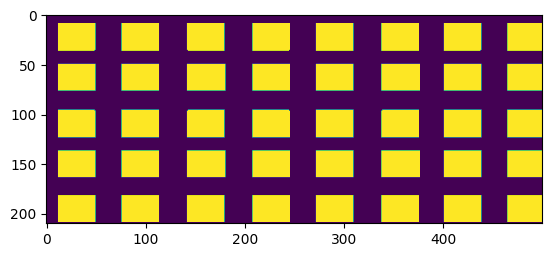

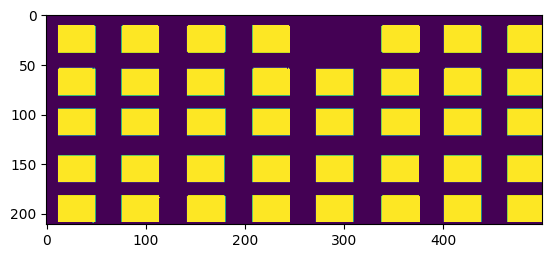

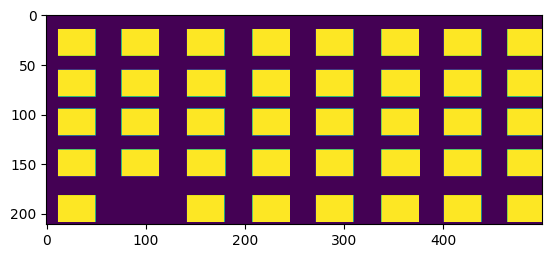

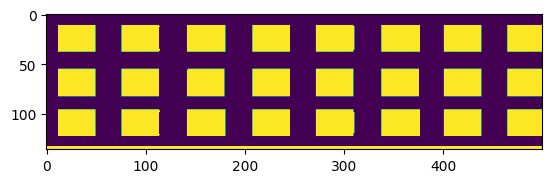

In [7]:
layout_name = "37.png"  
path = os.path.join( os.getcwd(), 'images', layout_name)

adaptive_window = Adaptive_window(path, 500)
image = Image.open(path)

while True:
    start_row, end_row, flag = adaptive_window.get_window_rows()
    start_col = 0
    end_col = start_col + 500
    img = np.array( image.crop(( start_col, start_row, end_col, end_row )) ) [:,:,0]
    img_bin = my_preprocessing(img)
    plt.imshow(img_bin)
    plt.show()
    
    if flag:
        break